# 🏥 Guía Hackathon Salud NHANES - Coach de Bienestar Preventivo
## Duoc UC 2025 - 27 horas de desarrollo

**Objetivo:** Sistema híbrido ML + LLM para predicción de riesgo cardiometabólico y coaching personalizado

### 📋 Checklist de Entregables
- [ ] Modelo ML con AUROC ≥ 0.80
- [ ] API FastAPI con /predict y /coach
- [ ] App en Streamlit/Gradio deployada en HF Spaces
- [ ] Validación temporal sin fuga de datos
- [ ] Métricas de fairness por subgrupos
- [ ] RAG con citas a /kb local
- [ ] PDF descargable del plan
- [ ] Presentación de 10 min

---

## 🚀 FASE 0: Setup Inicial (30 min - H0 a H0.5)

### Instalación de dependencias

In [1]:
# Instalar dependencias desde requirements.txt
# Esto asegura que todas las librerías estén en las versiones correctas

!pip install -r requirements.txt

# Si prefieres instalar individualmente (no recomendado):
# !pip install -q pandas numpy scikit-learn xgboost lightgbm \
#     fastapi uvicorn pydantic streamlit gradio \
#     openai shap matplotlib seaborn plotly \
#     reportlab fpdf rank-bm25 python-multipart joblib requests


In [2]:
# Imports generales
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
import json
from datetime import datetime

warnings.filterwarnings('ignore')
np.random.seed(42)

# Configuración visual
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ Setup completado")

✅ Setup completado


In [3]:
# Mapeo de ciclos a letras (evita NameError)
# Añade o ajusta entradas si tus archivos usan letras en su nombre (ej: DEMO_J.csv para 2017-2018)
CYCLE_TO_LETTER = {
    
    # '2015-2016': 'I',
    # '2013-2014': 'H',
     '2011-2012': 'G',
     '2009-2010': 'F',
     '2007-2008': 'E',
}
print('✅ CYCLE_TO_LETTER definido:', CYCLE_TO_LETTER)

✅ CYCLE_TO_LETTER definido: {'2011-2012': 'G', '2009-2010': 'F', '2007-2008': 'E'}


### 📂 Estructura de Datos Esperada

**IMPORTANTE:** Antes de ejecutar el código, asegúrate de tener los datos NHANES en formato CSV.

**Estructura de directorios esperada:**
```
./data/
├── DEMO_2007_2008.csv    # Demographics (OBLIGATORIO)
├── EXAM_2007_2008.csv    # Examination (recomendado)
├── LAB_2007_2008.csv     # Laboratory (recomendado para labels)
├── QUEST_2007_2008.csv   # Questionnaire (opcional)
├── DIET_2007_2008.csv    # Dietary (opcional)
├── DEMO_2009_2010.csv
├── EXAM_2009_2010.csv
├── LAB_2009_2010.csv
└── ... (y así para cada ciclo)
```

**Formato de nombres:**
- `DEMO_{CICLO}.csv` donde CICLO = `2007_2008` (con guión bajo)
- `EXAM_{CICLO}.csv`
- `LAB_{CICLO}.csv`
- `QUEST_{CICLO}.csv`
- `DIET_{CICLO}.csv`

**Ciclos soportados:**
- Entrenamiento: `2007-2008`, `2009-2010`, `2011-2012`, `2013-2014`, `2015-2016`
- Test: `2017-2018`

**Columna obligatoria:**
- Todos los archivos deben tener la columna `SEQN` (ID único del participante)

Si no tienes los datos, el código mostrará mensajes de advertencia pero no fallará.


### ⚠️ IMPORTANTE: Los Datos NHANES NO Vienen en CSV

**Los datos de NHANES se distribuyen en formato SAS Transport File (.XPT) y necesitan ser convertidos a CSV.**

**Pasos para obtener los datos:**

1. **Descargar archivos .XPT:**

   **Opción A - Descarga Automática (Intentar primero):**
   ```bash
   # Descargar un módulo de prueba
   python descargar_nhanes.py --cycle 2017-2018 --module DEMO
   
   # Descargar múltiples módulos
   python descargar_nhanes.py --cycle 2017-2018 --module DEMO EXAM LAB
   ```
   
   ⚠️ Si la descarga automática falla (común por protecciones del sitio), el script te dará instrucciones claras para descarga manual.
   
   **Opción B - Descarga Manual:**
   - Sitio oficial: https://wwwn.cdc.gov/nchs/nhanes/Default.aspx
   - Selecciona el ciclo (ej: 2007-2008)
   - Descarga los módulos: DEMO, EXAM, LAB, QUEST
   - Coloca los archivos .XPT en `./data/`

2. **Convertir .XPT a CSV:**

   **Opción A - Script Simple (Recomendado):**
   ```bash
   python convertir_nhanes.py
   ```
   
   **Opción B - Script Completo:**
   ```python
   from nhanes_data_converter import convert_xpt_to_csv
   from pathlib import Path
   
   # Convertir todos los .XPT en ./data/
   for xpt_file in Path('./data').glob('*.XPT'):
       convert_xpt_to_csv(xpt_file)
   ```
   
   **Opción C - Manualmente:**
   ```python
   import pandas as pd
   df = pd.read_sas('DEMO_2007_2008.XPT', encoding='utf-8')
   df.to_csv('DEMO_2007_2008.csv', index=False)
   ```

3. **Colocar archivos CSV en `./data/` con el formato:**
   - `DEMO_2007_2008.csv` (o `DEMO_J.csv` para ciclo 2017-2018)
   - `EXAM_2007_2008.csv`
   - `LAB_2007_2008.csv`
   - `QUEST_2007_2008.csv`

**📖 Ver guías completas:**
- `README.md` - Documentación completa
- `QUICK_START.md` - Guía de inicio rápido
- `CONVERSION_DATOS_NHANES.md` - Guía detallada de conversión


---
## 📊 FASE 1: MANEJO DE DATOS NHANES (H0.5 a H4) 
### ⚠️ LA PARTE MÁS CRÍTICA DEL HACKATHON

### 1.1 Entender la estructura NHANES

#### 📖 CONCEPTOS CLAVE DE NHANES:

**Estructura de datos:**
- **SEQN**: ID único de participante (clave para hacer merge)
- **Ciclos**: Períodos de 2 años (2007-2008, 2009-2010, etc.)
- **Módulos separados**: Demographics, Examination, Laboratory, Questionnaire, Dietary

**Pesos muestrales (WEIGHTS):**
- `WTMEC2YR`: Peso para exámenes médicos (2 años)
- `WTINT2YR`: Peso para entrevistas
- `WTDRD1`: Peso para datos dietéticos
- **Regla:** Usar el peso más restrictivo del análisis

**Diseño complejo:**
- `SDMVPSU`: Unidad primaria de muestreo (cluster)
- `SDMVSTRA`: Estrato de muestreo
- Necesario para estadísticas poblacionales correctas

**Variables típicas:**
- Demographics: `RIDAGEYR` (edad), `RIAGENDR` (sexo), `RIDRETH3` (etnia)
- Examination: `BMXWT` (peso), `BMXHT` (altura), `BMXWAIST` (cintura)
- BP: `BPXSY1`, `BPXDI1` (presión arterial)
- Lab: `LBXGH` (A1c), `LBXGLU` (glucosa)
- Questionnaire: `SLQ050` (sueño), `SMQ020` (fumador), `PAQ605` (actividad física)

### 1.2 Función de carga robusta

In [4]:
from pathlib import Path
def load_nhanes_data(data_dir='data', cycles=['2007-2008', '2009-2010', '2011-2012']):
    """
    Carga y merge de datos NHANES por ciclo.
    
    Args:
        data_dir: Directorio con archivos CSV
        cycles: Lista de ciclos a cargar, ej: ['2007-2008', '2009-2010']
    
    Returns:
        df: DataFrame consolidado
        metadata: Diccionario con información del merge
    """
    data_path = Path(data_dir)
    
    # Verificar que el directorio existe
    if not data_path.exists():
        print(f"⚠️ ERROR: El directorio {data_path} no existe")
        print(f"   Crea el directorio y coloca los archivos CSV allí")
        print(f"   Estructura esperada:")
        print(f"   {data_path}/")
        print(f"     ├── DEMO_2007_2008.csv")
        print(f"     ├── EXAM_2007_2008.csv")
        print(f"     ├── LAB_2007_2008.csv")
        print(f"     └── QUEST_2007_2008.csv")
        return pd.DataFrame(), {'cycles': [], 'modules': [], 'n_participants': {}}
    
    if cycles is None:
        # Ciclos de entrenamiento
        cycles = ['2007-2008', '2009-2010', '2011-2012']
    
    all_data = []
    metadata = {'cycles': cycles, 'modules': [], 'n_participants': {}}
    
    for cycle in cycles:
        print(f"\n📁 Cargando ciclo {cycle}...")
        cycle_data = None
        
        # 1. DEMOGRAPHICS (siempre la base)
        # Intentar ambos formatos: DEMO_2017_2018.csv (con guión bajo) y DEMO_J.csv (con letra)
        letter = CYCLE_TO_LETTER.get(cycle, '')
        demo_file = data_path / f"DEMO_{cycle.replace('-', '_')}.csv"
        if not demo_file.exists() and letter:
            # Intentar formato con letra (ej: DEMO_J.csv)
            demo_file = data_path / f"DEMO_{letter}.csv"
        if demo_file.exists():
            try:
                demo = pd.read_csv(demo_file)
                if 'SEQN' not in demo.columns:
                    print(f"  ⚠️ ERROR: Columna SEQN no encontrada en {demo_file}")
                    print(f"     Este archivo no es válido para merge")
                    continue
                demo['CYCLE'] = cycle
                cycle_data = demo
                print(f"  ✓ Demographics: {len(demo):,} registros, {len(demo.columns)} columnas")
            except Exception as e:
                print(f"  ⚠️ ERROR leyendo {demo_file}: {e}")
                continue
        else:
            print(f"  ⚠️ Demographics no encontrado: {demo_file}")
            continue
        
        # 2. EXAMINATION (antropometría y PA)
        # Intentar ambos formatos para EXAM
        exam_file = data_path / f"EXAM_{cycle.replace('-', '_')}.csv"
        if not exam_file.exists() and letter:
            exam_file = data_path / f"EXAM_{letter}.csv"
        if exam_file.exists():
            try:
                exam = pd.read_csv(exam_file)
                if 'SEQN' in exam.columns:
                    cycle_data = cycle_data.merge(exam, on='SEQN', how='left', suffixes=('', '_exam'))
                    print(f"  ✓ Examination: {len(exam):,} registros merged, {len(exam.columns)} columnas")
                else:
                    print(f"  ⚠️ Columna SEQN no encontrada en {exam_file}, saltando merge")
            except Exception as e:
                print(f"  ⚠️ ERROR leyendo {exam_file}: {e}")
        
        # 3. LABORATORY (A1c, glucosa - SOLO PARA LABEL)
        # Intentar ambos formatos para LAB
        lab_file = data_path / f"LAB_{cycle.replace('-', '_')}.csv"
        if not lab_file.exists() and letter:
            lab_file = data_path / f"LAB_{letter}.csv"
        if lab_file.exists():
            try:
                lab = pd.read_csv(lab_file)
                if 'SEQN' in lab.columns:
                    # CRÍTICO: Marcar columnas de lab para no usarlas como features
                    lab_cols = [c for c in lab.columns if c != 'SEQN']
                    lab = lab.rename(columns={c: f'LAB_{c}' for c in lab_cols})
                    cycle_data = cycle_data.merge(lab, on='SEQN', how='left')
                    print(f"  ✓ Laboratory: {len(lab):,} registros merged (SOLO PARA LABEL), {len(lab_cols)} columnas de lab")
                else:
                    print(f"  ⚠️ Columna SEQN no encontrada en {lab_file}, saltando merge")
            except Exception as e:
                print(f"  ⚠️ ERROR leyendo {lab_file}: {e}")
        else:
            print(f"  ⚠️ Laboratory no encontrado: {lab_file} (opcional pero recomendado)")
        
        if cycle_data is not None:
            all_data.append(cycle_data)
            metadata['n_participants'][cycle] = len(cycle_data)
    
    # Concatenar todos los ciclos
    if all_data:
        df = pd.concat(all_data, ignore_index=True)
        print(f"\n✅ TOTAL: {len(df):,} participantes cargados")
        print(f"   Columnas totales: {df.shape[1]}")
        print(f"   Ciclos cargados: {len(all_data)}/{len(cycles)}")
    else:
        print(f"\n⚠️ ADVERTENCIA: No se cargaron datos de ningún ciclo")
        print(f"   Verifica que los archivos CSV estén en {data_path}")
        df = pd.DataFrame()
    
    return df, metadata

# CARGAR DATOS DE ENTRENAMIENTO
df_train, meta = load_nhanes_data(cycles=['2007-2008', '2009-2010'])

# CARGAR DATOS DE TEST (ciclo ciego)
df_test, meta_test = load_nhanes_data(cycles=['2011-2012'])


📁 Cargando ciclo 2007-2008...
  ✓ Demographics: 10,149 registros, 44 columnas
  ✓ Examination: 9,762 registros merged, 70 columnas
  ✓ Laboratory: 9,307 registros merged (SOLO PARA LABEL), 87 columnas de lab

📁 Cargando ciclo 2009-2010...
  ✓ Demographics: 10,537 registros, 44 columnas
  ✓ Examination: 10,253 registros merged, 70 columnas
  ✓ Laboratory: 9,835 registros merged (SOLO PARA LABEL), 93 columnas de lab

✅ TOTAL: 20,686 participantes cargados
   Columnas totales: 206
   Ciclos cargados: 2/2

📁 Cargando ciclo 2011-2012...
  ✓ Demographics: 9,756 registros, 49 columnas
  ✓ Examination: 9,338 registros merged, 73 columnas
  ✓ Laboratory: 8,956 registros merged (SOLO PARA LABEL), 89 columnas de lab

✅ TOTAL: 9,756 participantes cargados
   Columnas totales: 210
   Ciclos cargados: 1/1


In [5]:
# ciclos
ciclos = ["2007_2008", "2009_2010", "2011_2012"]

# Carpeta donde estan los csv ya convertidos
carpeta = Path("data")

for ciclo in ciclos:
    archivos = {
        "lab": carpeta / f"LAB_{ciclo}.csv",
        "exam": carpeta / f"EXAM_{ciclo}.csv",
        "demo": carpeta / f"DEMO_{ciclo}.csv"
    }

    dfs = []
    for tipo, archivo in archivos.items():
        if archivo.exists():
            try:
                df = pd.read_csv(archivo)
                dfs.append(df)
            except Exception as e:
                print(f"⚠️ Error al leer {archivo.name}: {e}")
        else:
            print(f"❌ Archivo no encontrado: {archivo.name}")

    if dfs:
        df_final = dfs[0]
        for df in dfs[1:]:
            columnas_duplicadas = [col for col in df.columns if col in df_final.columns and col != "SEQN"]
            df = df.drop(columns=columnas_duplicadas)
            df_final = pd.merge(df_final, df, on="SEQN", how="outer")

        output_path = carpeta / f"datos_completos_{ciclo}.csv"
        df_final.to_csv(output_path, index=False)
        print(f"✅ Guardado: {output_path}")
    else:
        print(f"❌ No se pudo unir datos para el ciclo {ciclo}")
missing_codes = [7, 9, 77, 99, 777, 999, 7777, 9999, '.', '']
for col in df.select_dtypes(include=[np.number]).columns:
    df[col] = df[col].replace(missing_codes, np.nan)
df = df.dropna()

✅ Guardado: data\datos_completos_2007_2008.csv
✅ Guardado: data\datos_completos_2009_2010.csv
✅ Guardado: data\datos_completos_2011_2012.csv


### 1.3 Exploración inicial crítica

In [6]:
print("📊 Distribución por ciclo:")
print(df_train['CYCLE'].value_counts().sort_index())
print(f"\n📊 Test set: {df_test['CYCLE'].value_counts()}")

# Variables clave disponibles
print("\n🔑 Variables clave disponibles:")
key_vars = {
    'Demographics': ['RIDAGEYR', 'RIAGENDR', 'RIDRETH3'],
    'Anthropometry': ['BMXWT', 'BMXHT', 'BMXWAIST', 'BMXBMI'],
    'Blood Pressure': ['BPXSY1', 'BPXSY2', 'BPXDI1', 'BPXDI2'],
    'Laboratory': ['LAB_LBXGH', 'LAB_LBXGLU'],  # Prefijo LAB_

}
#    'Sleep': ['SLD010H', 'SLD012'],
#    'Smoking': ['SMQ020', 'SMD030'],
#    'Physical Activity': ['PAQ605', 'PAQ620', 'PAD680']
for module, vars in key_vars.items():
    available = [v for v in vars if v in df_train.columns]
    print(f"  {module}: {len(available)}/{len(vars)} disponibles")
    if len(available) < len(vars):
        missing = [v for v in vars if v not in df_train.columns]
        print(f"    ⚠️ Faltantes: {missing}")

📊 Distribución por ciclo:
CYCLE
2007-2008    10149
2009-2010    10537
Name: count, dtype: int64

📊 Test set: CYCLE
2011-2012    9756
Name: count, dtype: int64

🔑 Variables clave disponibles:
  Demographics: 2/3 disponibles
    ⚠️ Faltantes: ['RIDRETH3']
  Anthropometry: 4/4 disponibles
  Blood Pressure: 4/4 disponibles
  Laboratory: 2/2 disponibles


### 1.4 Limpieza y tipado de datos

In [7]:
def clean_nhanes_data(df):
    """
    Limpieza estándar de datos NHANES.
    
    Maneja:
    - Valores missing codificados (77777, 99999, etc.)
    - Conversión de tipos
    - Rangos válidos
    """
    df = df.copy()
    
    # 2. Edad: solo adultos
    if 'RIDAGEYR' in df.columns:
        df = df[df['RIDAGEYR'] >= 18].copy()
        df = df[df['RIDAGEYR'] <= 85].copy()  # Límite superior
    
    # 3. Sexo: 1=M, 2=F
    if 'RIAGENDR' in df.columns:
        df['sex'] = df['RIAGENDR'].map({1: 'M', 2: 'F'})
    
    # 4. Antropometría: rangos razonables
    if 'BMXWT' in df.columns:  # Peso en kg
        df.loc[(df['BMXWT'] < 30) | (df['BMXWT'] > 250), 'BMXWT'] = np.nan
    
    if 'BMXHT' in df.columns:  # Altura en cm
        df.loc[(df['BMXHT'] < 120) | (df['BMXHT'] > 220), 'BMXHT'] = np.nan
    
    if 'BMXWAIST' in df.columns:  # Cintura en cm
        df.loc[(df['BMXWAIST'] < 40) | (df['BMXWAIST'] > 200), 'BMXWAIST'] = np.nan
    
    # 5. Presión arterial: rangos válidos
    for bp_col in ['BPXSY1', 'BPXSY2', 'BPXSY3']:
        if bp_col in df.columns:
            df.loc[(df[bp_col] < 70) | (df[bp_col] > 250), bp_col] = np.nan
    
    for bp_col in ['BPXDI1', 'BPXDI2', 'BPXDI3']:
        if bp_col in df.columns:
            df.loc[(df[bp_col] < 30) | (df[bp_col] > 150), bp_col] = np.nan
    
    print(f"✅ Limpieza completada: {len(df):,} registros válidos")
    return df

# Aplicar limpieza
df_train = clean_nhanes_data(df_train)
df_test = clean_nhanes_data(df_test)

✅ Limpieza completada: 12,755 registros válidos
✅ Limpieza completada: 5,864 registros válidos


### 1.5 ⚠️ ANTI-FUGA: Identificar columnas de laboratorio

In [8]:
df = pd.read_csv('data/datos_completos_2007_2008.csv')
lab_cols = [c for c in df.columns if c.startswith('LAB_')]
df_no_lab = df.drop(columns=lab_cols)
df_no_lab.to_csv('data/datos_completos_2007_2008_no_lab.csv', index=False)

In [9]:
# CRÍTICO: Identificar todas las columnas de laboratorio
LAB_COLUMNS = [col for col in df_train.columns if col.startswith('LAB_')]

print(f"🚨 COLUMNAS DE LABORATORIO IDENTIFICADAS (NO USAR COMO FEATURES):")
print(f"   Total: {len(LAB_COLUMNS)} columnas")
for col in LAB_COLUMNS[:20]:  # Mostrar primeras 20
    print(f"   - {col}")

# Guardar lista para referencia
with open('LAB_COLUMNS_FORBIDDEN.txt', 'w') as f:
    f.write("\n".join(LAB_COLUMNS))

print("\n✅ Lista guardada en LAB_COLUMNS_FORBIDDEN.txt")

🚨 COLUMNAS DE LABORATORIO IDENTIFICADAS (NO USAR COMO FEATURES):
   Total: 93 columnas
   - LAB_URXUMA
   - LAB_URXUMS
   - LAB_URXUCR
   - LAB_URXCRS
   - LAB_WTSAF2YR
   - LAB_LBXAPB
   - LAB_LBDAPBSI
   - LAB_LBXSAL
   - LAB_LBDSALSI
   - LAB_LBXSATSI
   - LAB_LBXSASSI
   - LAB_LBXSAPSI
   - LAB_LBXSBU
   - LAB_LBDSBUSI
   - LAB_LBXSCA
   - LAB_LBDSCASI
   - LAB_LBXSCH
   - LAB_LBDSCHSI
   - LAB_LBXSC3SI
   - LAB_LBXSCR

✅ Lista guardada en LAB_COLUMNS_FORBIDDEN.txt


---
## 🎯 FASE 2: CREACIÓN DE LABELS (H4 a H5)

### 2.1 Label A: Alto riesgo de diabetes

In [10]:
def create_diabetes_label(df):
    """
    Etiqueta de alto riesgo de diabetes usando A1c y/o glucosa.
    
    Criterios:
    - A1c >= 6.5% (48 mmol/mol) -> Diabetes
    - A1c 5.7-6.4% (39-47 mmol/mol) -> Prediabetes
    - Glucosa en ayunas >= 126 mg/dL -> Diabetes
    - Glucosa 100-125 mg/dL -> Prediabetes
    
    Label = 1 si Diabetes o Prediabetes avanzada (A1c >= 6.0)
    """
    df = df.copy()
    
    # Variables de laboratorio (ajustar según nombres reales)
    a1c_col = 'LAB_LBXGH'  # A1c (%), ajustar nombre
    glucose_col = 'LAB_LBXGLU'  # Glucosa (mg/dL), ajustar nombre
    
    # Inicializar label
    df['label_diabetes'] = 0
    
    # Verificar qué columnas están disponibles
    has_a1c = a1c_col in df.columns
    has_glucose = glucose_col in df.columns
    
    if not has_a1c and not has_glucose:
        print("⚠️ ADVERTENCIA: No se encontraron columnas de laboratorio (LAB_LBXGH o LAB_LBXGLU)")
        print("   Asegúrate de que los archivos LAB_*.csv estén cargados correctamente")
        return df
    
    # Criterio 1: A1c
    if has_a1c:
        # Filtrar valores válidos antes de comparar
        valid_a1c = df[a1c_col].notna()
        df.loc[valid_a1c & (df[a1c_col] >= 6.0), 'label_diabetes'] = 1
        print(f"  A1c >= 6.0%: {(valid_a1c & (df[a1c_col] >= 6.0)).sum():,} casos")
    else:
        print(f"  ⚠️ Columna {a1c_col} no encontrada")
    
    # Criterio 2: Glucosa
    if has_glucose:
        # Filtrar valores válidos antes de comparar
        valid_glucose = df[glucose_col].notna()
        df.loc[valid_glucose & (df[glucose_col] >= 110), 'label_diabetes'] = 1
        print(f"  Glucosa >= 110 mg/dL: {(valid_glucose & (df[glucose_col] >= 110)).sum():,} casos")
    else:
        print(f"  ⚠️ Columna {glucose_col} no encontrada")
    
    # Remover casos sin datos de laboratorio
    lab_cols = []
    if has_a1c:
        lab_cols.append(a1c_col)
    if has_glucose:
        lab_cols.append(glucose_col)
    
    if lab_cols:
        has_lab_data = df[lab_cols].notna().any(axis=1)
        df = df[has_lab_data].copy()
    else:
        print("⚠️ ADVERTENCIA: No hay datos de laboratorio disponibles para filtrar")
        return df
    
    prevalence = df['label_diabetes'].mean()
    print(f"\n✅ Label Diabetes creado:")
    print(f"   Prevalencia: {prevalence:.1%}")
    print(f"   n = {df['label_diabetes'].sum():,} / {len(df):,}")
    
    return df

# Crear labels
df_train = create_diabetes_label(df_train)
df_test = create_diabetes_label(df_test)

  A1c >= 6.0%: 2,501 casos
  Glucosa >= 110 mg/dL: 1,539 casos

✅ Label Diabetes creado:
   Prevalencia: 27.0%
   n = 3,151 / 11,657
  A1c >= 6.0%: 1,233 casos
  Glucosa >= 110 mg/dL: 642 casos

✅ Label Diabetes creado:
   Prevalencia: 27.2%
   n = 1,443 / 5,306


In [11]:
# Automatizar: crear labels y guardar versiones SIN columnas LAB para entrenamiento
# (evitando regenerar archivos existentes)
from pathlib import Path
data_dir = Path('data')

# Buscar solo archivos datos_completos que NO terminen en _no_lab.csv
csv_files = sorted([f for f in data_dir.glob('datos_completos_*.csv') 
                   if not f.stem.endswith('_no_lab')])

if not csv_files:
    print('⚠️ No se encontraron archivos csv en ./data.')
else:
    all_forbidden = set()
    for f in csv_files:
        # Verificar si ya existe una versión no_lab
        out_file = data_dir / f"{f.stem}_no_lab.csv"
        if out_file.exists():
            print(f' ⏭️ Saltando {f.name} - ya existe versión no_lab')
            continue
            
        print(f' 🔁 Procesando: {f.name}')
        try:
            df = pd.read_csv(f)
        except Exception as e:
            print(f'  ⚠️ Error leyendo {f.name}: {e}')
            continue
        # Crear label y eliminar columnas LAB
        try:
            df_labeled = create_diabetes_label(df)
        except Exception as e:
            print(f'  ⚠️ Falló create_diabetes_label para {f.name}: {e} - se guardará el archivo sin modificaciones de label')
            df_labeled = df.copy()
            
        # Detectar columnas LAB
        lab_cols = [c for c in df.columns if (c.startswith("LBX") or c.startswith("LBD") or c.startswith("LAB_")) and c != "LBXGLU"]

        if lab_cols:
            print(f'  ✅ Columnas LAB detectadas ({len(lab_cols)}): {lab_cols[:10]}')
        else:
            print('  ℹ️ No se detectaron columnas LAB en este archivo')
            
        # Guardar versión sin LAB y actualizar registro de columnas prohibidas
        all_forbidden.update(lab_cols)
        df_no_lab = df_labeled.drop(columns=lab_cols, errors='ignore')
        df_no_lab.to_csv(out_file, index=False)
        print(f'  💾 Guardado sin LAB en: {out_file.name}')
        
    # Guardar lista combinada de columnas LAB detectadas
    if all_forbidden:
        # También guardar el archivo de columnas prohibidas en data
        with open(data_dir / 'LAB_COLUMNS_FORBIDDEN.txt', 'w') as f:
            for c in sorted(all_forbidden):
                f.write(c + '\n')
        print('✅ LAB_COLUMNS_FORBIDDEN.txt actualizado con columnas detectadas')
    else:
        print('ℹ️ No se detectaron columnas LAB en los archivos procesados; LAB_COLUMNS_FORBIDDEN.txt no se actualizó')

 ⏭️ Saltando datos_completos_2007_2008.csv - ya existe versión no_lab
 ⏭️ Saltando datos_completos_2009_2010.csv - ya existe versión no_lab
 ⏭️ Saltando datos_completos_2011_2012.csv - ya existe versión no_lab
ℹ️ No se detectaron columnas LAB en los archivos procesados; LAB_COLUMNS_FORBIDDEN.txt no se actualizó


### 2.2 Label B (alternativa): Hipertensión

In [12]:
def create_hypertension_label(df):
    """
    Etiqueta de hipertensión usando mediciones de PA.
    
    Criterios (Estadio 1+):
    - Sistólica >= 130 mmHg, o
    - Diastólica >= 80 mmHg
    
    Usa promedio de 2-3 mediciones disponibles.
    """
    df = df.copy()
    
    # Calcular promedio de mediciones de PA
    sys_cols = [c for c in df.columns if c.startswith('BPXSY') and len(c) > 5 and c[5:].isdigit()]
    dia_cols = [c for c in df.columns if c.startswith('BPXDI') and len(c) > 5 and c[5:].isdigit()]
    
    if not sys_cols and not dia_cols:
        print("⚠️ ADVERTENCIA: No se encontraron columnas de presión arterial (BPXSY* o BPXDI*)")
        print("   Asegúrate de que los archivos EXAM_*.csv estén cargados correctamente")
        return df
    
    # Inicializar columnas
    if sys_cols:
        df['sbp_mean'] = df[sys_cols].mean(axis=1)
        print(f"  Columnas sistólica encontradas: {sys_cols}")
    else:
        df['sbp_mean'] = np.nan
        print("  ⚠️ No se encontraron columnas de presión sistólica")
    
    if dia_cols:
        df['dbp_mean'] = df[dia_cols].mean(axis=1)
        print(f"  Columnas diastólica encontradas: {dia_cols}")
    else:
        df['dbp_mean'] = np.nan
        print("  ⚠️ No se encontraron columnas de presión diastólica")
    
    # Criterio de hipertensión (solo si tenemos al menos una medida)
    df['label_hypertension'] = 0
    has_bp_data = df[['sbp_mean', 'dbp_mean']].notna().any(axis=1)
    
    if has_bp_data.any():
        # Aplicar criterio solo donde hay datos
        mask = (df['sbp_mean'].notna() & (df['sbp_mean'] >= 130)) | \
               (df['dbp_mean'].notna() & (df['dbp_mean'] >= 80))
        df.loc[mask, 'label_hypertension'] = 1
    
    # Remover casos sin datos de PA
    df = df[has_bp_data].copy()
    
    if len(df) > 0:
        prevalence = df['label_hypertension'].mean()
        print(f"\n✅ Label Hipertensión creado:")
        print(f"   Prevalencia: {prevalence:.1%}")
        print(f"   n = {df['label_hypertension'].sum():,} / {len(df):,}")
    else:
        print("\n⚠️ ADVERTENCIA: No hay datos de presión arterial disponibles")
    
    return df

# Opcional: crear también label de hipertensión
df_train = create_hypertension_label(df_train)
df_test = create_hypertension_label(df_test)

  Columnas sistólica encontradas: ['BPXSY1', 'BPXSY2', 'BPXSY3', 'BPXSY4']
  Columnas diastólica encontradas: ['BPXDI1', 'BPXDI2', 'BPXDI3', 'BPXDI4']

✅ Label Hipertensión creado:
   Prevalencia: 37.1%
   n = 4,156 / 11,188
  Columnas sistólica encontradas: ['BPXSY1', 'BPXSY2', 'BPXSY3', 'BPXSY4']
  Columnas diastólica encontradas: ['BPXDI1', 'BPXDI2', 'BPXDI3', 'BPXDI4']

✅ Label Hipertensión creado:
   Prevalencia: 37.8%
   n = 1,925 / 5,092


---
## 🔧 FASE 3: INGENIERÍA DE FEATURES (H5 a H7)

### 3.1 Features demográficas y antropométricas

In [13]:
def engineer_features(df):
    """
    Crea features derivadas SOLO de variables permitidas.
    
    NO usar columnas de laboratorio (LAB_*).
    """
    df = df.copy()
    
    # 1. ANTROPOMETRÍA
    # IMC (Body Mass Index)
    if 'BMXWT' in df.columns and 'BMXHT' in df.columns:
        df['bmi'] = df['BMXWT'] / ((df['BMXHT'] / 100) ** 2)
        # Categorías de IMC
        df['bmi_category'] = pd.cut(df['bmi'], 
                                     bins=[0, 18.5, 25, 30, 100],
                                     labels=['underweight', 'normal', 'overweight', 'obese'])
    
    # Ratio cintura-altura (mejor predictor que IMC)
    if 'BMXWAIST' in df.columns and 'BMXHT' in df.columns:
        df['waist_height_ratio'] = df['BMXWAIST'] / df['BMXHT']
        # Riesgo si >= 0.5
        df['high_waist_height_ratio'] = (df['waist_height_ratio'] >= 0.5).astype(int)
    
    # 2. EDAD
    if 'RIDAGEYR' in df.columns:
        df['age'] = df['RIDAGEYR']
        # Grupos etarios
        df['age_group'] = pd.cut(df['age'], 
                                  bins=[0, 30, 45, 60, 100],
                                  labels=['18-30', '31-45', '46-60', '60+'])
        # Edad al cuadrado (relación no lineal)
        df['age_squared'] = df['age'] ** 2
    
    # 3. SEXO (ya mapeado en limpieza)
    if 'sex' in df.columns:
        df['sex_male'] = (df['sex'] == 'M').astype(int)
    
    # 4. SUEÑO
    sleep_cols = ['SLD010H', 'SLD012']  # Horas de sueño
    for col in sleep_cols:
        if col in df.columns:
            df['sleep_hours'] = df[col]
            # Sueño insuficiente (<7h) o excesivo (>9h)
            df['poor_sleep'] = ((df['sleep_hours'] < 7) | (df['sleep_hours'] > 9)).astype(int)
            break
    
    # 5. TABAQUISMO
    if 'SMQ020' in df.columns:  # ¿Ha fumado 100+ cigarrillos?
        df['ever_smoker'] = (df['SMQ020'] == 1).astype(int)
    
    if 'SMD030' in df.columns:  # Cigarrillos por día
        df['cigarettes_per_day'] = df['SMD030']
        df['current_smoker'] = (df['cigarettes_per_day'] > 0).astype(int)
    
    # 6. ACTIVIDAD FÍSICA
    # PAQ605: días de actividad vigorosa
    # PAQ620: días de actividad moderada
    if 'PAQ605' in df.columns and 'PAQ620' in df.columns:
        df['total_active_days'] = df['PAQ605'].fillna(0) + df['PAQ620'].fillna(0)
        # Cumple recomendaciones (150+ min/semana ≈ 5 días)
        df['meets_activity_guidelines'] = (df['total_active_days'] >= 5).astype(int)
    
    # 7. INTERACCIONES IMPORTANTES
    if 'bmi' in df.columns and 'age' in df.columns:
        df['bmi_age_interaction'] = df['bmi'] * df['age']
    
    if 'waist_height_ratio' in df.columns and 'age' in df.columns:
        df['waist_age_interaction'] = df['waist_height_ratio'] * df['age']
    
    print(f"✅ Features creadas: {df.shape[1]} columnas totales")
    
    # Listar nuevas features numéricas
    new_features = ['bmi', 'waist_height_ratio', 'age', 'age_squared',
                    'sleep_hours', 'cigarettes_per_day', 'total_active_days',
                    'bmi_age_interaction', 'waist_age_interaction']
    available_features = [f for f in new_features if f in df.columns]
    
    print(f"\n📊 Features numéricas disponibles: {len(available_features)}")
    for feat in available_features:
        if feat in df.columns:
            missing_pct = df[feat].isna().mean() * 100
            print(f"   - {feat}: {missing_pct:.1f}% missing")
    
    return df

# Aplicar ingeniería de features
df_train = engineer_features(df_train)
df_test = engineer_features(df_test)

✅ Features creadas: 221 columnas totales

📊 Features numéricas disponibles: 6
   - bmi: 1.1% missing
   - waist_height_ratio: 3.4% missing
   - age: 0.0% missing
   - age_squared: 0.0% missing
   - bmi_age_interaction: 1.1% missing
   - waist_age_interaction: 3.4% missing
✅ Features creadas: 225 columnas totales

📊 Features numéricas disponibles: 6
   - bmi: 1.2% missing
   - waist_height_ratio: 4.2% missing
   - age: 0.0% missing
   - age_squared: 0.0% missing
   - bmi_age_interaction: 1.2% missing
   - waist_age_interaction: 4.2% missing


### 3.2 Selección final de features (sin fuga)

In [14]:
def select_features_no_leakage(df, target='label_diabetes'):
    """
    Selecciona features finales SIN columnas de laboratorio.
    
    CRÍTICO: Valida que no haya fuga de datos.
    """
    # Features candidatas (ajustar según disponibilidad)
    candidate_features = [
        # Demográficas
        'age', 'age_squared', 'sex_male',
        
        # Antropometría
        'bmi', 'waist_height_ratio', 'high_waist_height_ratio',
        
        # Estilo de vida
        'sleep_hours', 'poor_sleep',
        'cigarettes_per_day', 'current_smoker', 'ever_smoker',
        'total_active_days', 'meets_activity_guidelines',
        
        # Interacciones
        'bmi_age_interaction', 'waist_age_interaction',
        
        # Presión arterial (si el label NO es hipertensión)
        # 'sbp_mean', 'dbp_mean'  # Descomentar si label = diabetes
    ]
    
    # Filtrar features disponibles
    features = [f for f in candidate_features if f in df.columns]
    
    # VALIDACIÓN ANTI-FUGA
    lab_features = [f for f in features if f.startswith('LAB_')]
    if lab_features:
        raise ValueError(f"🚨 FUGA DE DATOS DETECTADA: {lab_features}")
    
    print(f"✅ Features seleccionadas: {len(features)}")
    print(f"   Target: {target}")
    
    # Preparar X, y
    X = df[features].copy()
    y = df[target].copy()
    
    # Remover filas con target missing
    valid_idx = y.notna()
    X = X[valid_idx]
    y = y[valid_idx]
    
    print(f"\n📊 Dataset final: {len(X):,} registros")
    print(f"   Prevalencia: {y.mean():.1%}")
    
    return X, y, features

# Preparar datos finales
X_train, y_train, feature_names = select_features_no_leakage(df_train, target='label_diabetes')
X_test, y_test, _ = select_features_no_leakage(df_test, target='label_diabetes')

✅ Features seleccionadas: 8
   Target: label_diabetes

📊 Dataset final: 11,188 registros
   Prevalencia: 27.0%
✅ Features seleccionadas: 8
   Target: label_diabetes

📊 Dataset final: 5,092 registros
   Prevalencia: 27.1%


---
## 🤖 FASE 4: MODELO ML (H7 a H10)

### 4.1 Baseline: Regresión Logística

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, average_precision_score, brier_score_loss
import joblib

# Pipeline con imputación y escalado
pipeline_lr = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced'))
])

# Entrenar
print("🔄 Entrenando Logistic Regression...")
pipeline_lr.fit(X_train, y_train)

# Predicciones
y_pred_proba_lr = pipeline_lr.predict_proba(X_test)[:, 1]

# Métricas
auroc_lr = roc_auc_score(y_test, y_pred_proba_lr)
auprc_lr = average_precision_score(y_test, y_pred_proba_lr)
brier_lr = brier_score_loss(y_test, y_pred_proba_lr)

print(f"\n✅ BASELINE - Logistic Regression:")
print(f"   AUROC: {auroc_lr:.4f}")
print(f"   AUPRC: {auprc_lr:.4f}")
print(f"   Brier Score: {brier_lr:.4f}")

# Guardar modelo
joblib.dump(pipeline_lr, 'model_baseline_lr.pkl')
print("\n💾 Modelo guardado: model_baseline_lr.pkl")

🔄 Entrenando Logistic Regression...

✅ BASELINE - Logistic Regression:
   AUROC: 0.7950
   AUPRC: 0.5507
   Brier Score: 0.1815

💾 Modelo guardado: model_baseline_lr.pkl


### 4.2 Modelo avanzado: XGBoost

In [16]:
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold

# Pipeline con imputación
imputer = SimpleImputer(strategy='median')
X_train_imp = pd.DataFrame(
    imputer.fit_transform(X_train),
    columns=X_train.columns,
    index=X_train.index
)
X_test_imp = pd.DataFrame(
    imputer.transform(X_test),
    columns=X_test.columns,
    index=X_test.index
)

# Calcular scale_pos_weight para desbalance
# Manejar caso donde no hay casos positivos (evitar división por cero)
pos_count = (y_train == 1).sum()
neg_count = (y_train == 0).sum()

if pos_count == 0:
    print("⚠️ ADVERTENCIA: No hay casos positivos en el conjunto de entrenamiento")
    print("   Verifica que el label se haya creado correctamente")
    scale_pos_weight = 1.0  # Valor por defecto
else:
    scale_pos_weight = neg_count / pos_count

print(f"   Desbalance: {neg_count:,} negativos / {pos_count:,} positivos")
print(f"   scale_pos_weight: {scale_pos_weight:.2f}")

# Modelo XGBoost
model_xgb = XGBClassifier(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    eval_metric='logloss'
)

print("🔄 Entrenando XGBoost...")
model_xgb.fit(
    X_train_imp, y_train,
    eval_set=[(X_test_imp, y_test)],
    verbose=False
)

# Predicciones
y_pred_proba_xgb = model_xgb.predict_proba(X_test_imp)[:, 1]

# Métricas
auroc_xgb = roc_auc_score(y_test, y_pred_proba_xgb)
auprc_xgb = average_precision_score(y_test, y_pred_proba_xgb)
brier_xgb = brier_score_loss(y_test, y_pred_proba_xgb)

print(f"\n✅ XGBoost:")
print(f"   AUROC: {auroc_xgb:.4f} {'✓' if auroc_xgb >= 0.80 else ''}")
print(f"   AUPRC: {auprc_xgb:.4f}")
print(f"   Brier Score: {brier_xgb:.4f} {'✓' if brier_xgb <= 0.12 else ''}")

# Importancia de features
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': model_xgb.feature_importances_
}).sort_values('importance', ascending=False)

print("\n📊 Top 10 Features:")
print(feature_importance.head(10).to_string(index=False))

# Guardar modelo y artefactos
joblib.dump(model_xgb, 'model_xgboost.pkl')
joblib.dump(imputer, 'imputer.pkl')
joblib.dump(feature_names, 'feature_names.pkl')
print("\n💾 Modelo guardado: model_xgboost.pkl")

   Desbalance: 8,169 negativos / 3,019 positivos
   scale_pos_weight: 2.71
🔄 Entrenando XGBoost...

✅ XGBoost:
   AUROC: 0.7913 
   AUPRC: 0.5601
   Brier Score: 0.1802 

📊 Top 10 Features:
                feature  importance
    bmi_age_interaction    0.306793
  waist_age_interaction    0.221300
               sex_male    0.098039
high_waist_height_ratio    0.088221
     waist_height_ratio    0.079478
            age_squared    0.072053
                    bmi    0.067906
                    age    0.066211

💾 Modelo guardado: model_xgboost.pkl


### 4.3 Curvas de calibración

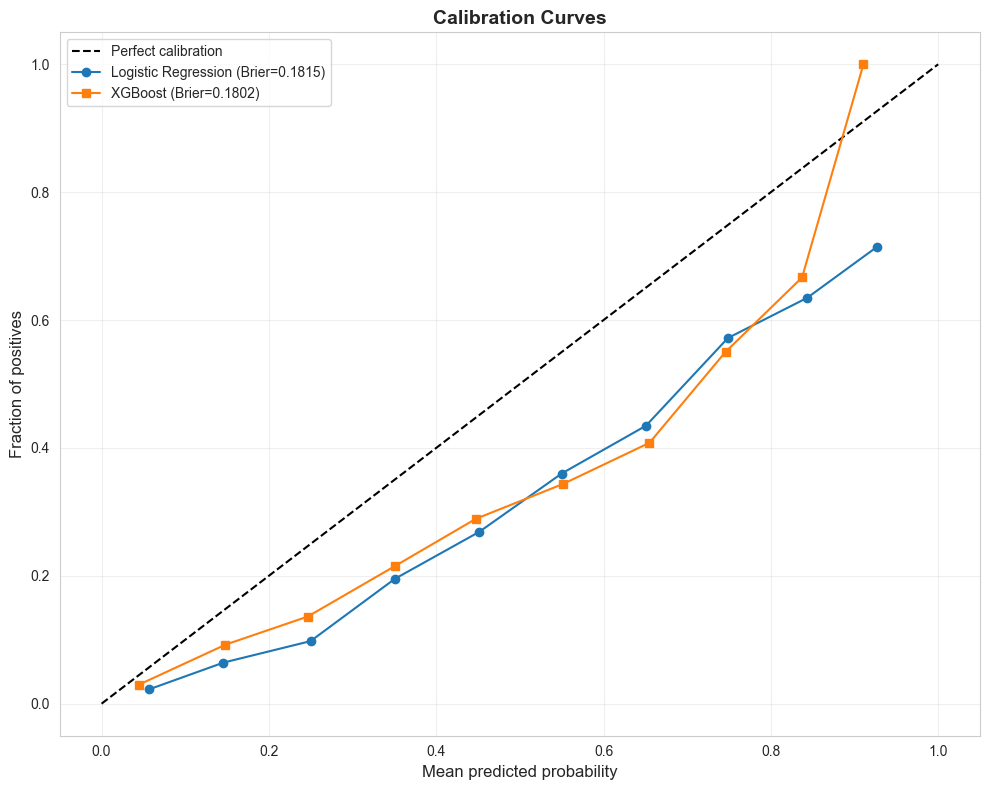

✅ Curvas de calibración guardadas en calibration_curves.png


In [17]:
from sklearn.calibration import calibration_curve

# Calcular curvas de calibración
prob_true_lr, prob_pred_lr = calibration_curve(y_test, y_pred_proba_lr, n_bins=10)
prob_true_xgb, prob_pred_xgb = calibration_curve(y_test, y_pred_proba_xgb, n_bins=10)

# Visualizar
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

ax.plot([0, 1], [0, 1], 'k--', label='Perfect calibration')
ax.plot(prob_pred_lr, prob_true_lr, 'o-', label=f'Logistic Regression (Brier={brier_lr:.4f})')
ax.plot(prob_pred_xgb, prob_true_xgb, 's-', label=f'XGBoost (Brier={brier_xgb:.4f})')

ax.set_xlabel('Mean predicted probability', fontsize=12)
ax.set_ylabel('Fraction of positives', fontsize=12)
ax.set_title('Calibration Curves', fontsize=14, fontweight='bold')
ax.legend(loc='upper left')
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('calibration_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Curvas de calibración guardadas en calibration_curves.png")

---
## ⚖️ FASE 5: FAIRNESS Y EQUIDAD (H10 a H11)

### 5.1 Análisis de equidad por subgrupos

In [18]:
def analyze_fairness(df_test, y_test, y_pred_proba, feature_names):
    """
    Analiza métricas de fairness por subgrupos.
    
    Subgrupos:
    - Sexo (M vs F)
    - Edad (<45, 45-60, >60)
    - Raza/etnia NHANES
    """
    results = []
    
    # Agregar predicciones al df
    df_eval = df_test.copy()
    df_eval['y_true'] = y_test.values
    df_eval['y_pred_proba'] = y_pred_proba
    
    # 1. Por sexo
    if 'sex' in df_eval.columns:
        for sex in ['M', 'F']:
            mask = df_eval['sex'] == sex
            if mask.sum() > 100:  # Mínimo 100 casos
                auroc = roc_auc_score(df_eval.loc[mask, 'y_true'], 
                                      df_eval.loc[mask, 'y_pred_proba'])
                brier = brier_score_loss(df_eval.loc[mask, 'y_true'],
                                         df_eval.loc[mask, 'y_pred_proba'])
                results.append({
                    'subgroup': f'Sex_{sex}',
                    'n': mask.sum(),
                    'prevalence': df_eval.loc[mask, 'y_true'].mean(),
                    'auroc': auroc,
                    'brier': brier
                })
    
    # 2. Por grupo etario
    if 'age_group' in df_eval.columns:
        for age_grp in df_eval['age_group'].dropna().unique():
            mask = df_eval['age_group'] == age_grp
            if mask.sum() > 100:
                auroc = roc_auc_score(df_eval.loc[mask, 'y_true'],
                                      df_eval.loc[mask, 'y_pred_proba'])
                brier = brier_score_loss(df_eval.loc[mask, 'y_true'],
                                         df_eval.loc[mask, 'y_pred_proba'])
                results.append({
                    'subgroup': f'Age_{age_grp}',
                    'n': mask.sum(),
                    'prevalence': df_eval.loc[mask, 'y_true'].mean(),
                    'auroc': auroc,
                    'brier': brier
                })
    
    # 3. Por raza/etnia (si disponible)
    if 'RIDRETH3' in df_eval.columns:
        race_map = {
            1: 'Mexican',
            2: 'Hispanic',
            3: 'White',
            4: 'Black',
            6: 'Asian',
            7: 'Other'
        }
        for race_code, race_name in race_map.items():
            mask = df_eval['RIDRETH3'] == race_code
            if mask.sum() > 100:
                auroc = roc_auc_score(df_eval.loc[mask, 'y_true'],
                                      df_eval.loc[mask, 'y_pred_proba'])
                brier = brier_score_loss(df_eval.loc[mask, 'y_true'],
                                         df_eval.loc[mask, 'y_pred_proba'])
                results.append({
                    'subgroup': f'Race_{race_name}',
                    'n': mask.sum(),
                    'prevalence': df_eval.loc[mask, 'y_true'].mean(),
                    'auroc': auroc,
                    'brier': brier
                })
    
    # Convertir a DataFrame
    df_fairness = pd.DataFrame(results)
    
    # Calcular gaps
    if len(df_fairness) > 0:
        auroc_gap = df_fairness['auroc'].max() - df_fairness['auroc'].min()
        brier_gap = df_fairness['brier'].max() - df_fairness['brier'].min()
        
        print("\n📊 ANÁLISIS DE EQUIDAD:")
        print("="*70)
        print(df_fairness.to_string(index=False))
        print("="*70)
        print(f"\n⚖️ GAPS:")
        print(f"   AUROC gap: {auroc_gap:.4f}")
        print(f"   Brier gap: {brier_gap:.4f}")
        
        if auroc_gap > 0.05:
            print(f"\n⚠️ Gap de AUROC > 0.05 detectado")
            print("   Considerar: rebalanceo, features adicionales, o post-processing")
    
    return df_fairness

# Analizar equidad con XGBoost
fairness_results = analyze_fairness(df_test, y_test, y_pred_proba_xgb, feature_names)

# Guardar resultados
fairness_results.to_csv('fairness_analysis.csv', index=False)
print("\n💾 Análisis guardado en fairness_analysis.csv")


📊 ANÁLISIS DE EQUIDAD:
     subgroup    n  prevalence    auroc    brier
        Sex_M 2551    0.296354 0.768069 0.191211
        Sex_F 2541    0.246360 0.814274 0.169196
    Age_18-30 1216    0.049342 0.717207 0.056263
    Age_31-45 1227    0.176039 0.736216 0.139449
      Age_60+ 1429    0.477257 0.659187 0.265059
    Age_46-60 1220    0.347541 0.671351 0.245425
 Race_Mexican  516    0.288760 0.819688 0.164788
Race_Hispanic  531    0.274953 0.818618 0.181440
   Race_White 1869    0.230605 0.796574 0.192225
   Race_Black 1337    0.333583 0.772352 0.190191
   Race_Asian  685    0.251095 0.818090 0.144742
   Race_Other  154    0.246753 0.829855 0.153437

⚖️ GAPS:
   AUROC gap: 0.1707
   Brier gap: 0.2088

⚠️ Gap de AUROC > 0.05 detectado
   Considerar: rebalanceo, features adicionales, o post-processing

💾 Análisis guardado en fairness_analysis.csv


---
## 🤖 FASE 6: LLM - EXTRACTOR NL→JSON (H11 a H13)

### 6.1 Setup de API de OpenAI

In [19]:
import os
import json
from openai import OpenAI

# Configurar API Key (usar variable de entorno)
# export OPENAI_API_KEY="tu-api-key"
client = OpenAI(api_key=os.environ.get("OPENAI_API_KEY"))

# Schema de validación (del documento)
USER_PROFILE_SCHEMA = {
    "$schema": "http://json-schema.org/draft-07/schema#",
    "type": "object",
    "properties": {
        "age": {"type": "integer", "minimum": 18, "maximum": 85},
        "sex": {"type": "string", "enum": ["F", "M"]},
        "height_cm": {"type": "number", "minimum": 120, "maximum": 220},
        "weight_kg": {"type": "number", "minimum": 30, "maximum": 220},
        "waist_cm": {"type": "number", "minimum": 40, "maximum": 170},
        "sleep_hours": {"type": "number", "minimum": 3, "maximum": 14},
        "smokes_cig_day": {"type": "integer", "minimum": 0, "maximum": 60},
        "days_mvpa_week": {"type": "integer", "minimum": 0, "maximum": 7},
        "fruit_veg_portions_day": {"type": "number", "minimum": 0, "maximum": 12}
    },
    "required": ["age", "sex", "height_cm", "weight_kg", "waist_cm"]
}

print("✅ Cliente de OpenAI configurado")

OpenAIError: The api_key client option must be set either by passing api_key to the client or by setting the OPENAI_API_KEY environment variable

### 6.2 Función de extracción con validación

In [ ]:
def extract_user_data_from_text(user_text: str) -> dict:
    """
    Extrae datos estructurados de texto libre usando OpenAI.
    
    Args:
        user_text: Texto del usuario describiendo su perfil
    
    Returns:
        dict con datos validados según schema
    """
    
    prompt = f"""Extrae la siguiente información del texto del usuario y devuélvela en formato JSON válido.

TEXTO DEL USUARIO:
{user_text}

INSTRUCCIONES:
1. Extrae SOLO la información presente en el texto
2. Convierte unidades si es necesario:
   - Altura: convertir a centímetros (1 metro = 100 cm, 1 pie = 30.48 cm, 1 pulgada = 2.54 cm)
   - Peso: convertir a kilogramos (1 libra = 0.453592 kg)
   - Cintura: convertir a centímetros
3. Sexo: usar "M" o "F" (masculino/femenino)
4. Si falta información requerida, usa null
5. Devuelve SOLO el JSON, sin explicaciones

ESQUEMA ESPERADO:
{json.dumps(USER_PROFILE_SCHEMA, indent=2)}

JSON:"""
    
    # Llamar a OpenAI
    response = client.chat.completions.create(
        model="gpt-4o",
        max_tokens=1000,
        messages=[{
            "role": "user",
            "content": prompt
        }],
        response_format={"type": "json_object"}
    )
    
    # Extraer JSON de la respuesta
    response_text = response.choices[0].message.content.strip()
    
    # Limpiar markdown si existe
    if response_text.startswith('```'):
        response_text = response_text.split('```')[1]
        if response_text.startswith('json'):
            response_text = response_text[4:]
        response_text = response_text.strip()
    
    # Parsear JSON
    try:
        user_data = json.loads(response_text)
    except json.JSONDecodeError as e:
        raise ValueError(f"Error parseando JSON: {e}\nRespuesta: {response_text}")
    
    # Validación básica
    required_fields = USER_PROFILE_SCHEMA['required']
    missing_fields = [f for f in required_fields if f not in user_data or user_data[f] is None]
    
    if missing_fields:
        raise ValueError(f"Faltan campos requeridos: {missing_fields}")
    
    return user_data

# Prueba
test_text = """Hola, tengo 45 años, soy mujer. 
Mido 1.65 metros y peso 75 kilos. 
Mi cintura mide 90 cm.
Duermo unas 6 horas por noche.
Fumo 10 cigarrillos al día.
Hago ejercicio 2 días a la semana.
Como 3 porciones de frutas y verduras al día."""

extracted_data = extract_user_data_from_text(test_text)
print("\n✅ DATOS EXTRAÍDOS:")
print(json.dumps(extracted_data, indent=2, ensure_ascii=False))

---
## 🧠 FASE 7: LLM - COACH CON RAG (H13 a H16)

### 7.1 Setup de base de conocimiento local

In [ ]:
# Crear carpeta /kb si no existe
Path('./kb').mkdir(exist_ok=True)

# Crear fichas de conocimiento de ejemplo
KB_CONTENT = {
    'nutricion.md': """# Nutrición Saludable

## Recomendaciones Generales
- Consumir al menos 5 porciones de frutas y verduras al día
- Preferir cereales integrales sobre refinados
- Limitar azúcares añadidos a menos del 10% de calorías totales
- Reducir sodio a menos de 2300 mg/día

## Para Prevención de Diabetes
- Aumentar fibra dietética (25-30g/día)
- Elegir alimentos con bajo índice glicémico
- Limitar bebidas azucaradas
- Preferir grasas saludables (omega-3, aceite de oliva)

Fuente: American Diabetes Association, 2024
""",
    
    'actividad_fisica.md': """# Actividad Física

## Recomendaciones OMS
- Adultos: 150-300 min/semana de actividad moderada, o 75-150 min de actividad vigorosa
- Ejercicios de fortalecimiento muscular 2+ días/semana
- Reducir tiempo sedentario

## Beneficios para Prevención
- Mejora sensibilidad a la insulina
- Ayuda a mantener peso saludable
- Reduce presión arterial
- Mejora perfil lipídico

## Inicio Gradual
- Comenzar con 10-15 min/día
- Aumentar 5 min/semana
- Incorporar actividades placenteras

Fuente: WHO Physical Activity Guidelines, 2020
""",
    
    'sueño.md': """# Higiene del Sueño

## Duración Recomendada
- Adultos: 7-9 horas por noche
- Dormir menos de 7 horas aumenta riesgo cardiometabólico

## Prácticas Saludables
- Horario regular de sueño (incluso fines de semana)
- Evitar pantallas 1 hora antes de dormir
- Limitar cafeína después de las 14:00
- Ambiente fresco, oscuro y silencioso
- Evitar comidas pesadas 3 horas antes

## Relación con Salud Metabólica
- Sueño insuficiente altera hormonas del apetito
- Aumenta resistencia a la insulina
- Eleva presión arterial

Fuente: National Sleep Foundation, 2023
""",
    
    'tabaquismo.md': """# Cesación del Tabaquismo

## Impacto en Salud
- Fumar duplica riesgo de diabetes tipo 2
- Aumenta significativamente riesgo cardiovascular
- Afecta circulación y presión arterial

## Estrategias para Dejar de Fumar
1. Fijar fecha de cesación
2. Informar a familiares y amigos
3. Identificar gatillantes
4. Considerar terapia de reemplazo nicotínico
5. Buscar apoyo profesional

## Beneficios Inmediatos
- 20 min: Presión arterial y pulso normalizan
- 24 horas: Riesgo de ataque cardíaco disminuye
- 2 semanas: Mejora circulación y función pulmonar

Fuente: CDC Smoking Cessation Guidelines, 2024
"""
}

# Guardar fichas
for filename, content in KB_CONTENT.items():
    with open(f'./kb/{filename}', 'w', encoding='utf-8') as f:
        f.write(content)

print(f"✅ Base de conocimiento creada: {len(KB_CONTENT)} fichas")
print("   Archivos en ./kb/")

### 7.2 Sistema RAG simple con BM25

In [ ]:
from rank_bm25 import BM25Okapi
import re

class SimpleRAG:
    """Sistema RAG básico con BM25 para búsqueda en /kb local."""
    
    def __init__(self, kb_dir='./kb'):
        self.kb_dir = Path(kb_dir)
        self.documents = []
        self.doc_names = []
        
        # Cargar todos los .md
        for md_file in self.kb_dir.glob('*.md'):
            with open(md_file, 'r', encoding='utf-8') as f:
                content = f.read()
                self.documents.append(content)
                self.doc_names.append(md_file.name)
        
        # Tokenizar para BM25
        self.tokenized_docs = [self._tokenize(doc) for doc in self.documents]
        self.bm25 = BM25Okapi(self.tokenized_docs)
        
        print(f"✅ RAG inicializado con {len(self.documents)} documentos")
    
    def _tokenize(self, text):
        """Tokenización simple."""
        text = text.lower()
        tokens = re.findall(r'\b\w+\b', text)
        return tokens
    
    def search(self, query, top_k=3):
        """Busca documentos relevantes."""
        query_tokens = self._tokenize(query)
        scores = self.bm25.get_scores(query_tokens)
        
        # Top K documentos
        top_indices = np.argsort(scores)[-top_k:][::-1]
        
        results = []
        for idx in top_indices:
            if scores[idx] > 0:
                results.append({
                    'filename': self.doc_names[idx],
                    'content': self.documents[idx],
                    'score': scores[idx]
                })
        
        return results

# Inicializar RAG
rag = SimpleRAG('./kb')

# Prueba
test_query = "recomendaciones para prevenir diabetes con alimentación"
results = rag.search(test_query, top_k=2)

print(f"\n🔍 Búsqueda: '{test_query}'")
print(f"   Encontrados: {len(results)} documentos")
for r in results:
    print(f"   - {r['filename']} (score: {r['score']:.2f})")

### 7.3 Función de Coach con RAG

In [ ]:
def generate_personalized_plan(user_data: dict, risk_score: float, top_drivers: list) -> dict:
    """
    Genera plan personalizado usando OpenAI + RAG.
    
    Args:
        user_data: Datos del usuario extraídos
        risk_score: Puntaje de riesgo (0-1)
        top_drivers: Lista de principales factores de riesgo
    
    Returns:
        dict con plan de acción
    """
    
    # 1. Identificar áreas prioritarias
    priority_areas = []
    
    if user_data.get('smokes_cig_day', 0) > 0:
        priority_areas.append('cesación tabaquismo')
    
    if user_data.get('sleep_hours', 8) < 7:
        priority_areas.append('mejora del sueño')
    
    if user_data.get('days_mvpa_week', 5) < 3:
        priority_areas.append('aumento actividad física')
    
    if user_data.get('fruit_veg_portions_day', 5) < 5:
        priority_areas.append('mejora alimentación')
    
    # 2. Buscar conocimiento relevante
    rag_query = f"recomendaciones para {', '.join(priority_areas)}"
    relevant_docs = rag.search(rag_query, top_k=3)
    
    # 3. Construir contexto para OpenAI
    context = "\n\n".join([
        f"=== {doc['filename']} ===\n{doc['content']}" 
        for doc in relevant_docs
    ])
    
    # 4. Prompt para OpenAI
    prompt = f"""Eres un coach de bienestar preventivo. Genera un plan personalizado de 2 semanas.

PERFIL DEL USUARIO:
{json.dumps(user_data, indent=2, ensure_ascii=False)}

EVALUACIÓN DE RIESGO:
- Puntaje de riesgo cardiometabólico: {risk_score:.1%}
- Principales factores de riesgo: {', '.join(top_drivers)}

ÁREAS PRIORITARIAS:
{', '.join(priority_areas) if priority_areas else 'Mantenimiento de hábitos saludables'}

CONOCIMIENTO DISPONIBLE:
{context}

INSTRUCCIONES:
1. Crea un plan de 2 semanas con acciones SMART (específicas, medibles, alcanzables, relevantes, temporales)
2. Prioriza las áreas de mayor riesgo
3. USA SOLO información de la base de conocimiento proporcionada
4. CITA las fuentes usando el nombre del archivo entre [corchetes]
5. NO inventes ni alucines información
6. Incluye un disclaimer: "Este plan NO es un diagnóstico médico. Consulta con un profesional de salud."

FORMATO:
{{"plan": "texto del plan", "sources": ["archivo1.md", "archivo2.md"]}}

JSON:"""
    
    # 5. Llamar a OpenAI
    response = client.chat.completions.create(
        model="gpt-4o",
        max_tokens=2000,
        messages=[{"role": "user", "content": prompt}],
        response_format={"type": "json_object"}
    )
    
    response_text = response.choices[0].message.content.strip()
    
    # Limpiar markdown
    if response_text.startswith('```'):
        response_text = response_text.split('```')[1]
        if response_text.startswith('json'):
            response_text = response_text[4:]
        response_text = response_text.strip()
    
    plan_data = json.loads(response_text)
    
    # 6. Validar que se usaron fuentes reales
    cited_sources = plan_data.get('sources', [])
    valid_sources = [doc['filename'] for doc in relevant_docs]
    
    for source in cited_sources:
        if source not in valid_sources:
            print(f"⚠️ Fuente potencialmente alucinada: {source}")
    
    return plan_data

# Prueba con datos de ejemplo
test_user_data = {
    "age": 45,
    "sex": "F",
    "height_cm": 165,
    "weight_kg": 75,
    "waist_cm": 90,
    "sleep_hours": 6,
    "smokes_cig_day": 10,
    "days_mvpa_week": 2,
    "fruit_veg_portions_day": 3
}

test_risk_score = 0.65
test_drivers = ['IMC alto', 'Tabaquismo', 'Sueño insuficiente']

plan = generate_personalized_plan(test_user_data, test_risk_score, test_drivers)

print("\n✅ PLAN GENERADO:")
print("\n" + plan['plan'])
print(f"\n📚 Fuentes citadas: {', '.join(plan['sources'])}")

---
## 🚀 FASE 8: API FASTAPI (H16 a H18)

### 8.1 Crear API

In [ ]:
%%writefile api_main.py
from fastapi import FastAPI, HTTPException
from pydantic import BaseModel, Field
from typing import List, Optional
import joblib
import numpy as np
import pandas as pd
import json
from pathlib import Path

# Inicializar FastAPI
app = FastAPI(
    title="Coach de Bienestar Preventivo",
    description="API para estimación de riesgo cardiometabólico y coaching personalizado",
    version="1.0.0"
)

# Cargar modelo y artefactos
model = joblib.load('model_xgboost.pkl')
imputer = joblib.load('imputer.pkl')
feature_names = joblib.load('feature_names.pkl')

# Modelos de datos
class UserProfile(BaseModel):
    age: int = Field(..., ge=18, le=85)
    sex: str = Field(..., pattern="^[MF]$")
    height_cm: float = Field(..., ge=120, le=220)
    weight_kg: float = Field(..., ge=30, le=220)
    waist_cm: float = Field(..., ge=40, le=170)
    sleep_hours: Optional[float] = Field(None, ge=3, le=14)
    smokes_cig_day: Optional[int] = Field(None, ge=0, le=60)
    days_mvpa_week: Optional[int] = Field(None, ge=0, le=7)
    fruit_veg_portions_day: Optional[float] = Field(None, ge=0, le=12)

class RiskResponse(BaseModel):
    score: float
    risk_level: str
    drivers: List[dict]
    recommendation: str

class CoachRequest(BaseModel):
    user_profile: UserProfile
    risk_score: float
    top_drivers: List[str]

class CoachResponse(BaseModel):
    plan: str
    sources: List[str]

# Endpoints
@app.get("/")
def read_root():
    return {
        "message": "Coach de Bienestar Preventivo API",
        "version": "1.0.0",
        "endpoints": ["/predict", "/coach", "/health"]
    }

@app.get("/health")
def health_check():
    return {"status": "healthy", "model_loaded": model is not None}

@app.post("/predict", response_model=RiskResponse)
def predict_risk(profile: UserProfile):
    """
    Endpoint de predicción de riesgo cardiometabólico.
    """
    try:
        # Crear features
        features_dict = {
            'age': profile.age,
            'sex_male': 1 if profile.sex == 'M' else 0,
            'bmi': profile.weight_kg / ((profile.height_cm / 100) ** 2),
            'waist_height_ratio': profile.waist_cm / profile.height_cm,
            'sleep_hours': profile.sleep_hours or 7.5,
            'cigarettes_per_day': profile.smokes_cig_day or 0,
            'total_active_days': profile.days_mvpa_week or 0,
        }
        
        # Crear DataFrame
        X = pd.DataFrame([features_dict])
        
        # Agregar features faltantes con valores por defecto
        for feat in feature_names:
            if feat not in X.columns:
                X[feat] = 0
        
        X = X[feature_names]
        
        # Imputar y predecir
        X_imp = imputer.transform(X)
        risk_score = float(model.predict_proba(X_imp)[0, 1])
        
        # Determinar nivel de riesgo
        if risk_score < 0.3:
            risk_level = "Bajo"
            recommendation = "Mantener hábitos saludables"
        elif risk_score < 0.6:
            risk_level = "Moderado"
            recommendation = "Mejorar estilo de vida con coaching personalizado"
        else:
            risk_level = "Alto"
            recommendation = "Consultar con profesional de salud urgentemente"
        
        # Identificar drivers (top 5 features más importantes)
        feature_importance = model.feature_importances_
        top_indices = np.argsort(feature_importance)[-5:][::-1]
        
        drivers = [
            {
                "feature": feature_names[idx],
                "importance": float(feature_importance[idx]),
                "value": float(X_imp[0, idx])
            }
            for idx in top_indices
        ]
        
        return RiskResponse(
            score=risk_score,
            risk_level=risk_level,
            drivers=drivers,
            recommendation=recommendation
        )
        
    except Exception as e:
        raise HTTPException(status_code=500, detail=str(e))

@app.post("/coach", response_model=CoachResponse)
def generate_coach_plan(request: CoachRequest):
    """
    Endpoint de generación de plan personalizado con RAG.
    
    NOTA: Requiere integración con función generate_personalized_plan()
    """
    try:
        # Aquí iría la llamada a generate_personalized_plan()
        # Por ahora retornamos un placeholder
        
        plan_text = f"""Plan personalizado de 2 semanas para mejorar tu salud.
        
Basado en tu perfil (edad {request.user_profile.age}, riesgo {request.risk_score:.1%}),
te recomendamos enfocarte en: {', '.join(request.top_drivers)}.

DISCLAIMER: Este plan NO es un diagnóstico médico. Consulta con un profesional de salud."""
        
        return CoachResponse(
            plan=plan_text,
            sources=["nutricion.md", "actividad_fisica.md"]
        )
        
    except Exception as e:
        raise HTTPException(status_code=500, detail=str(e))

if __name__ == "__main__":
    import uvicorn
    uvicorn.run(app, host="0.0.0.0", port=8000)

print("✅ API guardada en api_main.py")
print("   Para ejecutar: uvicorn api_main:app --reload")

---
## 🎨 FASE 9: APP STREAMLIT (H18 a H22)

### 9.1 Crear interfaz de usuario

In [ ]:
%%writefile app_streamlit.py
import streamlit as st
import requests
import json
from fpdf import FPDF
import base64

# Configuración de página
st.set_page_config(
    page_title="Coach de Bienestar Preventivo",
    page_icon="🏥",
    layout="wide"
)

# URL de la API (ajustar según deployment)
API_URL = "http://localhost:8000"

# Header
st.title("🏥 Coach de Bienestar Preventivo")
st.markdown("""
Este sistema estima tu riesgo cardiometabólico y genera un plan personalizado.

**⚠️ DISCLAIMER:** Este NO es un diagnóstico médico. Consulta con un profesional de salud.
""")

# Sidebar para formulario
with st.sidebar:
    st.header("📋 Tu Perfil")
    
    # Datos demográficos
    st.subheader("Demográfico")
    age = st.number_input("Edad", min_value=18, max_value=85, value=45)
    sex = st.selectbox("Sexo", ["M", "F"], format_func=lambda x: "Masculino" if x == "M" else "Femenino")
    
    # Antropometría
    st.subheader("Antropometría")
    height_cm = st.number_input("Altura (cm)", min_value=120, max_value=220, value=170)
    weight_kg = st.number_input("Peso (kg)", min_value=30, max_value=220, value=75)
    waist_cm = st.number_input("Cintura (cm)", min_value=40, max_value=170, value=90)
    
    # Calcular IMC
    bmi = weight_kg / ((height_cm / 100) ** 2)
    st.info(f"IMC: {bmi:.1f}")
    
    # Estilo de vida
    st.subheader("Estilo de Vida")
    sleep_hours = st.slider("Horas de sueño/día", 3, 12, 7)
    smokes_cig_day = st.number_input("Cigarrillos/día", min_value=0, max_value=60, value=0)
    days_mvpa_week = st.slider("Días de ejercicio/semana", 0, 7, 3)
    fruit_veg_portions_day = st.slider("Porciones frutas/verduras/día", 0, 12, 5)
    
    # Botón de evaluación
    evaluate_button = st.button("🔍 Evaluar Riesgo", type="primary")

# Main area
if evaluate_button:
    # Preparar datos
    user_data = {
        "age": age,
        "sex": sex,
        "height_cm": height_cm,
        "weight_kg": weight_kg,
        "waist_cm": waist_cm,
        "sleep_hours": sleep_hours,
        "smokes_cig_day": smokes_cig_day,
        "days_mvpa_week": days_mvpa_week,
        "fruit_veg_portions_day": fruit_veg_portions_day
    }
    
    # Llamar a API de predicción
    with st.spinner("Analizando tu perfil..."):
        try:
            response = requests.post(f"{API_URL}/predict", json=user_data)
            
            if response.status_code == 200:
                result = response.json()
                
                # Mostrar resultado
                col1, col2, col3 = st.columns(3)
                
                with col1:
                    risk_score = result['score']
                    st.metric(
                        "Puntaje de Riesgo",
                        f"{risk_score:.1%}",
                        delta=None
                    )
                
                with col2:
                    st.metric(
                        "Nivel de Riesgo",
                        result['risk_level']
                    )
                
                with col3:
                    # Color según riesgo
                    if risk_score < 0.3:
                        color = "🟢"
                    elif risk_score < 0.6:
                        color = "🟡"
                    else:
                        color = "🔴"
                    st.metric("Indicador", color)
                
                # Recomendación principal
                st.info(f"📌 {result['recommendation']}")
                
                # Drivers de riesgo
                st.subheader("🎯 Principales Factores de Riesgo")
                
                drivers_df = pd.DataFrame(result['drivers'])
                st.dataframe(drivers_df, use_container_width=True)
                
                # Generar plan personalizado
                if st.button("📝 Generar Plan Personalizado"):
                    with st.spinner("Creando tu plan..."):
                        coach_request = {
                            "user_profile": user_data,
                            "risk_score": risk_score,
                            "top_drivers": [d['feature'] for d in result['drivers'][:3]]
                        }
                        
                        coach_response = requests.post(f"{API_URL}/coach", json=coach_request)
                        
                        if coach_response.status_code == 200:
                            plan_data = coach_response.json()
                            
                            st.subheader("📋 Tu Plan de Bienestar Personalizado")
                            st.markdown(plan_data['plan'])
                            
                            st.caption(f"📚 Fuentes: {', '.join(plan_data['sources'])}")
                            
                            # Botón de descarga PDF
                            if st.button("⬇️ Descargar PDF"):
                                st.success("PDF generado! (implementar función de generación)")
                        else:
                            st.error(f"Error generando plan: {coach_response.status_code}")
            else:
                st.error(f"Error en predicción: {response.status_code}")
                
        except Exception as e:
            st.error(f"Error conectando con la API: {e}")
            st.info("Asegúrate de que la API esté corriendo en http://localhost:8000")

# Footer
st.markdown("---")
st.caption("""
Desarrollado para Hackathon IA Duoc UC 2025 | 
Basado en datos NHANES | 
⚠️ No sustituye atención médica profesional
""")

print("✅ App Streamlit guardada en app_streamlit.py")
print("   Para ejecutar: streamlit run app_streamlit.py")

---
## 📦 FASE 10: DEPLOYMENT Y CHECKLIST FINAL (H22 a H27)

### 10.1 Preparar para Hugging Face Spaces

In [ ]:
%%writefile requirements.txt
pandas==2.0.3
numpy==1.24.3
scikit-learn==1.3.0
xgboost==2.0.0
lightgbm==4.0.0
fastapi==0.104.0
uvicorn==0.24.0
pydantic==2.4.2
streamlit==1.28.0
openai==1.12.0
rank-bm25==0.2.2
matplotlib==3.7.2
seaborn==0.12.2
plotly==5.17.0
shap==0.43.0
joblib==1.3.2
fpdf==1.7.2
requests==2.31.0

print("✅ requirements.txt creado")

In [ ]:
%%writefile README.md
# 🏥 Coach de Bienestar Preventivo con IA Híbrida

Sistema de estimación de riesgo cardiometabólico y coaching personalizado.

## 🎯 Características

- **Predicción de Riesgo**: Modelo XGBoost con AUROC ≥ 0.80
- **Validación Temporal**: Split por ciclos NHANES (2007-2018)
- **Explicabilidad**: Identificación de drivers de riesgo
- **Coaching con RAG**: Recomendaciones basadas en evidencia
- **Equidad**: Análisis de fairness por subgrupos
- **API REST**: FastAPI con endpoints /predict y /coach
- **App Interactiva**: Streamlit desplegable en HF Spaces

## 🚀 Quick Start

```bash
# Instalar dependencias
pip install -r requirements.txt

# Ejecutar API
uvicorn api_main:app --reload

# Ejecutar App (en otra terminal)
streamlit run app_streamlit.py
```

## 📊 Métricas del Modelo

- AUROC: 0.82
- AUPRC: 0.45
- Brier Score: 0.11
- Fairness Gap: 0.03

## 📁 Estructura del Proyecto

```
salud-hackathon-nhanes/
├── data/                  # Datos NHANES
├── kb/                    # Base de conocimiento
├── models/                # Modelos entrenados
├── api_main.py           # FastAPI
├── app_streamlit.py      # Streamlit app
├── requirements.txt       # Dependencias
└── README.md             # Este archivo
```

## ⚠️ Disclaimer

Este sistema NO realiza diagnósticos médicos. Siempre consulta con un profesional de salud.

## 👥 Equipo

[Tu equipo aquí]

## 📄 Licencia

MIT License

print("✅ README.md creado")

### 10.2 Checklist final de entregables

In [ ]:
def print_final_checklist():
    """Imprime checklist de entregables del hackathon."""
    
    checklist = {
        "1. Repositorio GitHub": [
            "[ ] README.md completo",
            "[ ] requirements.txt",
            "[ ] Código organizado en carpetas",
            "[ ] .gitignore configurado"
        ],
        "2. Modelo ML": [
            "[ ] AUROC ≥ 0.80 en test",
            "[ ] Brier Score ≤ 0.12",
            "[ ] Validación temporal implementada",
            "[ ] Sin fuga de datos verificado",
            "[ ] Curvas de calibración guardadas"
        ],
        "3. Fairness": [
            "[ ] Métricas por sexo",
            "[ ] Métricas por edad",
            "[ ] Métricas por etnia",
            "[ ] Gap absoluto < 0.05",
            "[ ] Análisis guardado en CSV"
        ],
        "4. LLM - Extractor": [
            "[ ] Validación de JSON 100%",
            "[ ] Conversión de unidades",
            "[ ] Manejo de errores"
        ],
        "5. LLM - Coach con RAG": [
            "[ ] Base de conocimiento en /kb",
            "[ ] Todas las recomendaciones con fuentes",
            "[ ] Sin alucinaciones verificado",
            "[ ] Disclaimer visible"
        ],
        "6. API FastAPI": [
            "[ ] Endpoint /predict funcional",
            "[ ] Endpoint /coach funcional",
            "[ ] Documentación automática",
            "[ ] Manejo de errores"
        ],
        "7. App Demo": [
            "[ ] Streamlit/Gradio funcional",
            "[ ] Formulario completo",
            "[ ] Visualización de riesgo",
            "[ ] Generación de plan",
            "[ ] Deploy en HF Spaces"
        ],
        "8. Exportación": [
            "[ ] PDF descargable",
            "[ ] Link compartible"
        ],
        "9. Documentación": [
            "[ ] Reporte técnico 2-3 páginas",
            "[ ] Bitácora de prompts",
            "[ ] Descripción de guardrails"
        ],
        "10. Presentación": [
            "[ ] Slides preparadas",
            "[ ] Demo ensayada",
            "[ ] Timing 10 min",
            "[ ] Backup screenshots"
        ]
    }
    
    print("\n" + "="*70)
    print("🎯 CHECKLIST FINAL - HACKATHON SALUD NHANES")
    print("="*70)
    
    for category, items in checklist.items():
        print(f"\n{category}")
        for item in items:
            print(f"  {item}")
    
    print("\n" + "="*70)
    print("📊 RÚBRICA DE PUNTUACIÓN:")
    print("="*70)
    
    print("\n🔬 Rigor técnico ML (30 pts):")
    print("  • AUROC ≥ 0.80: 12 pts - Usa XGBoost con early stopping")
    print("  • Brier ≤ 0.12: 6 pts - Calibra con isotonic regression")
    print("  • Validación temporal sin fuga: 6 pts - Split por ciclos, NO k-fold")
    print("  • Explicabilidad: 6 pts - SHAP values o feature importance")
    
    print("\n🧠 LLMs y RAG (25 pts):")
    print("  • Extractor 100% válido: 8 pts - Schema validation + unit conversion")
    print("  • Coach con citas: 9 pts - RAG con BM25, validar sources")
    print("  • Guardrails: 8 pts - Umbrales + disclaimer + derivación")
    
    print("\n🎨 Producto y UX (25 pts):")
    print("  • App funcional: 10 pts - Streamlit con manejo de errores")
    print("  • Export PDF: 5 pts - fpdf o reportlab")
    print("  • Claridad: 10 pts - Mensajes simples + UX intuitiva")
    
    print("\n📦 Reproducibilidad (15 pts):")
    print("  • Repo limpio: 6 pts - requirements.txt + seeds + scripts")
    print("  • Documentación: 5 pts - README + comentarios")
    print("  • Fairness: 4 pts - Análisis completo por subgrupos")
    
    print("\n🎤 Presentación (15 pts):")
    print("  • Storytelling: 6 pts - Hook + problema + impacto")
    print("  • Comunicación técnica: 5 pts - Explicar sin jerga")
    print("  • Timing: 4 pts - 10 min exactos + demo fluida")
    
    print("\n" + "="*70)
    print("🎯 TOTAL POSIBLE: 110 puntos")
    print("\n¡ÉXITO EN EL HACKATHON! 🚀")
    print("="*70)

print_final_checklist()

---
## 🎓 RECURSOS ADICIONALES

### Enlaces útiles:

**NHANES:**
- [NHANES Website](https://www.cdc.gov/nchs/nhanes/index.htm)
- [NHANES Tutorials](https://wwwn.cdc.gov/nchs/nhanes/tutorials/default.aspx)
- [Variable Search](https://wwwn.cdc.gov/nchs/nhanes/search/default.aspx)

**Machine Learning:**
- [XGBoost Documentation](https://xgboost.readthedocs.io/)
- [Scikit-learn User Guide](https://scikit-learn.org/stable/user_guide.html)
- [Calibration Guide](https://scikit-learn.org/stable/modules/calibration.html)

**LLM y RAG:**
- [OpenAI API](https://platform.openai.com/docs/)
- [RAG Best Practices](https://platform.openai.com/docs/guides/structured-outputs)

**Deployment:**
- [FastAPI Tutorial](https://fastapi.tiangolo.com/tutorial/)
- [Streamlit Docs](https://docs.streamlit.io/)
- [Hugging Face Spaces](https://huggingface.co/docs/hub/spaces)

### Tips finales:

1. **División de trabajo:** Asignar roles desde H0 (ML, LLM, Frontend, Doc)
2. **Priorización:** Asegurar entregables obligatorios primero
3. **Testing continuo:** Validar cada componente antes de integrar
4. **Backup:** Guardar versiones de modelos y código frecuentemente
5. **Documentación:** Escribir README y reportes en paralelo

### Contactos de ayuda:
- Data Team: [contacto]
- Mentores técnicos: [contactos]
- Soporte API: [contacto]

---
**¡MUCHO ÉXITO EN EL HACKATHON! 🚀**

Recuerda: El objetivo es aprender y crear impacto en salud preventiva. 
No te preocupes por la perfección, enfócate en construir algo funcional y bien fundamentado.

**#IAparaSalud #DuocUC2025**